In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils
from dataset import LargeDataset

files = utils.list_files('../resources/', '.tif')
images = [f for f in files if not f.endswith('_mask.tif')]
images = [(i, i.replace('.tif', '_mask.tif')) for i in images]

dataset = LargeDataset(images, random_state=0)
dataset.end = 50 # ~20000 images

In [3]:
import time

start = time.time()

i = 0
for _ in dataset:
    i += 1

elapsed = time.time() - start

print('{} images loaded in {:.0f}m{:.0f}s'.format(i, elapsed // 60, elapsed % 60))

17970 images loaded in 0m23s


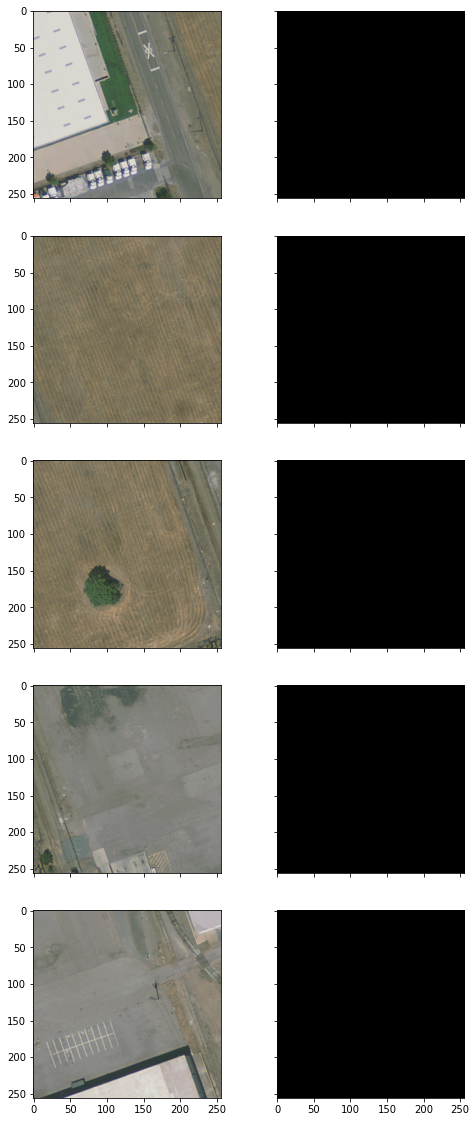

In [4]:
import torch.utils.data as data
from plots import plot_alongside

dataloader = data.DataLoader(dataset, batch_size=5, num_workers=0)

inputs, targets = iter(dataloader).next()

plot_alongside(inputs, targets)

In [5]:
import torch
from torchsummary import summary
from models import UNet

model = UNet(3, 1)
# model.load_state_dict(torch.load('products/models/unet.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

summary(model, input_size=(3, 256, 256))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1,

In [6]:
import criterions
# import torch.nn as nn
import torch.optim as optim

criterion = criterions.IoU() # nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
import numpy as np

model.train()

for epoch in range(10):
    print('Epoch {}'.format(epoch + 1))
    print('-' * 10)

    start = time.time()
    
    losses = list()

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = np.mean(losses)

    print('Loss = {}'.format(loss))

    elapsed = time.time() - start

    print('{:.0f}m{:.0f}s elapsed'.format(elapsed // 60, elapsed % 60))
    print('-' * 10)

Epoch 1
----------
Loss = 0.9347932572887551
15m42s elapsed
----------
Epoch 2
----------
Loss = 0.12696591858805453
15m49s elapsed
----------
Epoch 3
----------
Loss = 0.12688564045202355
15m49s elapsed
----------
Epoch 4
----------
Loss = 0.12687859534553905
15m48s elapsed
----------
Epoch 5
----------
Loss = 0.12687749569457177
15m54s elapsed
----------
Epoch 6
----------
Loss = 0.12687730235262717
15m51s elapsed
----------
Epoch 7
----------
Loss = 0.12687728401018503
15m51s elapsed
----------
Epoch 8
----------
Loss = 0.12687728401018503
15m56s elapsed
----------
Epoch 9
----------
Loss = 0.12687728401018503
15m60s elapsed
----------
Epoch 10
----------
Loss = 0.12687728401018503
16m0s elapsed
----------


In [8]:
import os

os.makedirs('../products/models/', exist_ok=True)

torch.save(model.state_dict(), '../products/models/unet.pth')

In [10]:
model.eval()

dataset.start = dataset.end
dataset.end += 5 # validation set

dataloader = data.DataLoader(dataset, batch_size=5, num_workers=0)

with torch.no_grad():
    losses = list()

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())

loss = np.mean(losses)

print('Loss = {}'.format(loss))

Loss = 0.12088091529715642


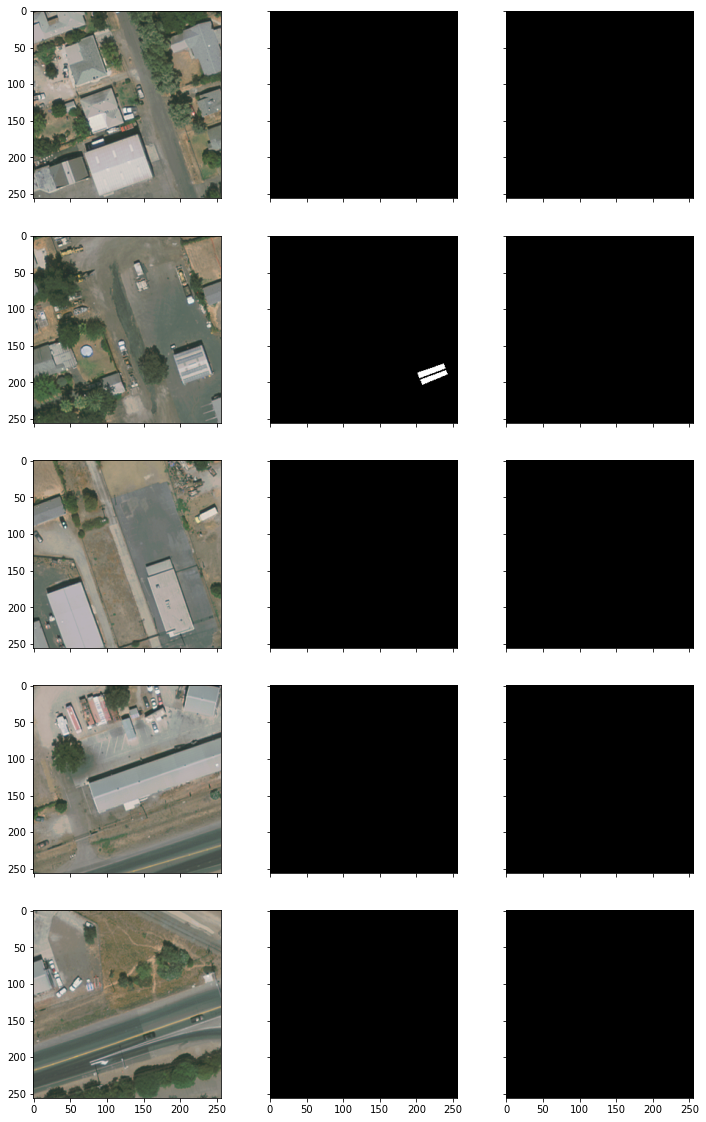

In [11]:
model.eval()

for inputs, targets in dataloader:
    if targets.sum().item() > 0:
        break

inputs = inputs.to(device)
targets = targets.to(device)
outputs = model(inputs)

plot_alongside(
    inputs.cpu(),
    targets.cpu(),
    outputs.cpu(),
)